In [5]:
%load_ext autoreload
%autoreload 2

from tweedejaars_project import *
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.compose import *
from sklearn.kernel_approximation import *
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.neural_network import *
from sklearn.linear_model import *
import xgboost as xgb
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, MissingIndicator
from statsmodels.tsa.statespace.sarimax import SARIMAX
from imblearn.over_sampling import SMOTE

from numba import jit

df = load_df()

version = "target"
target = "target_two_sided_ptu"
train_set = "train"
test_set = "valid"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Number of used features: 12
count    1.000000
mean    -0.058587
std           NaN
min     -0.058587
25%     -0.058587
50%     -0.058587
75%     -0.058587
max     -0.058587
Name: 0, dtype: float64


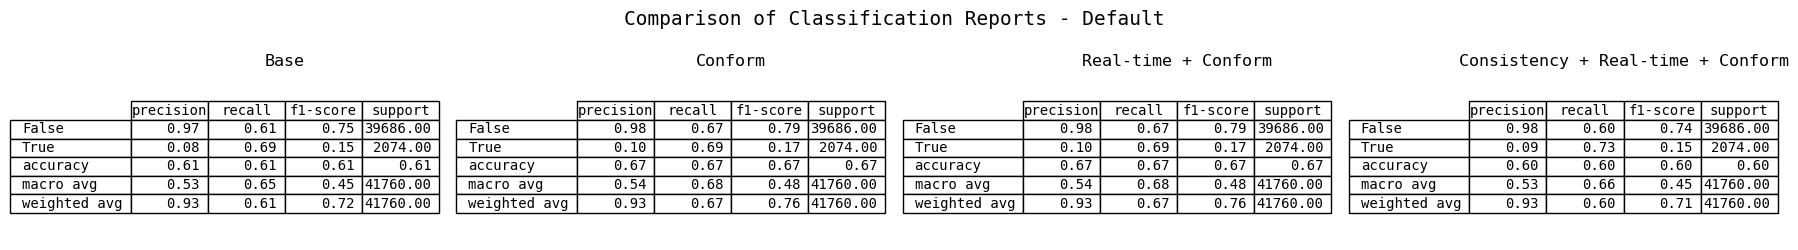

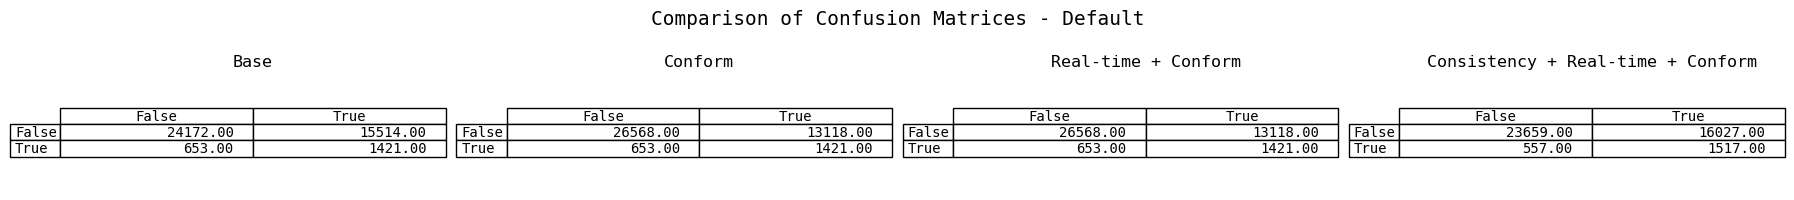

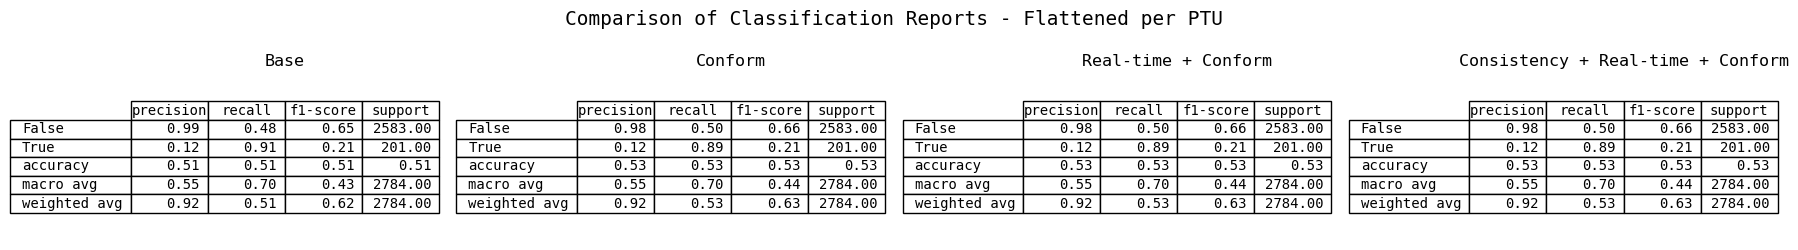

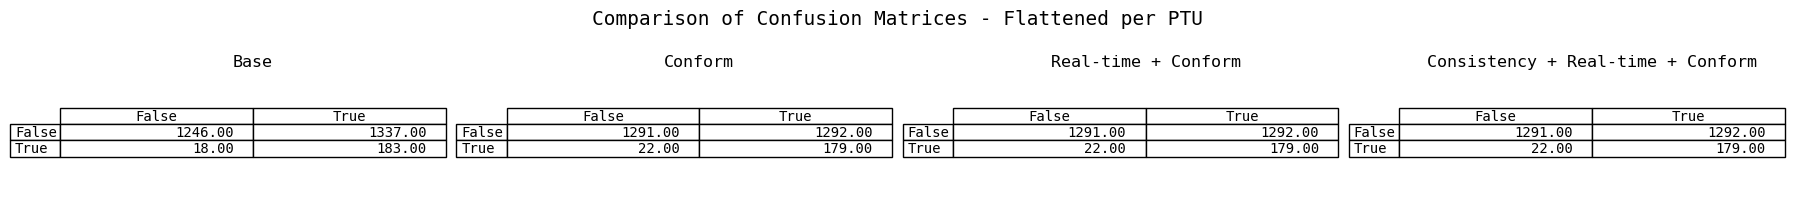

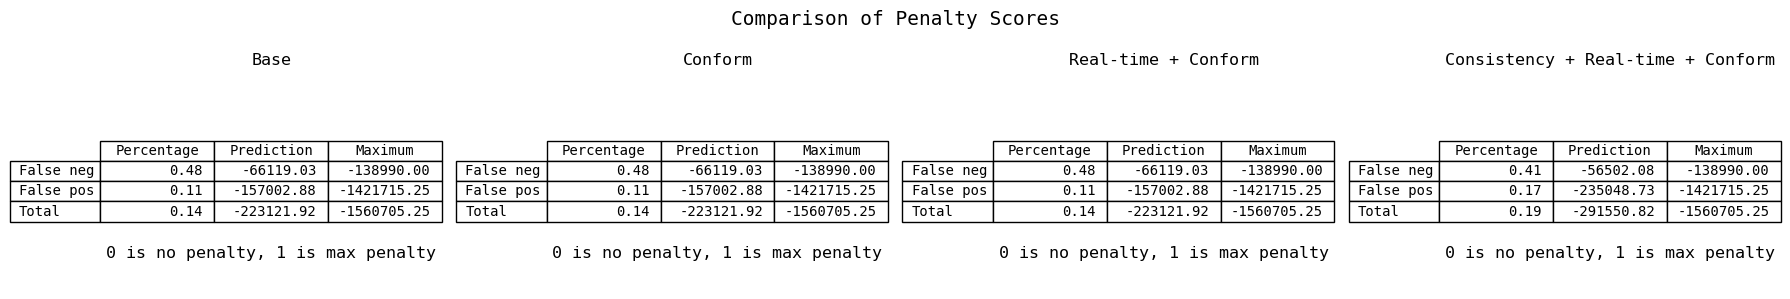

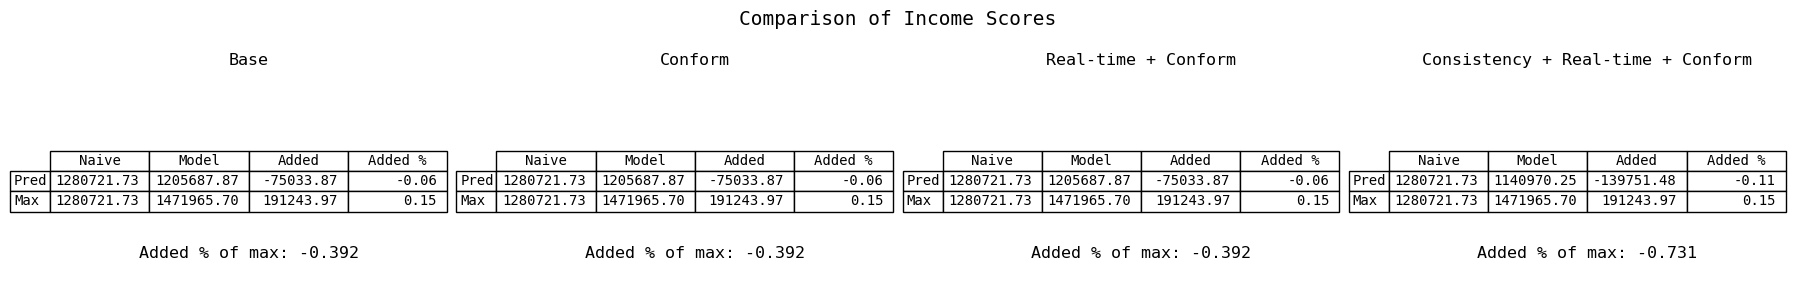

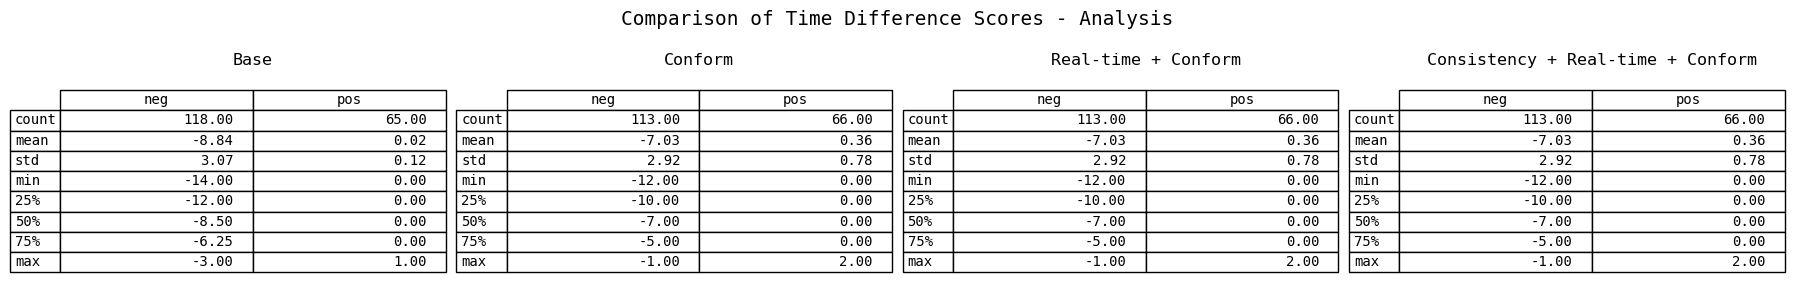

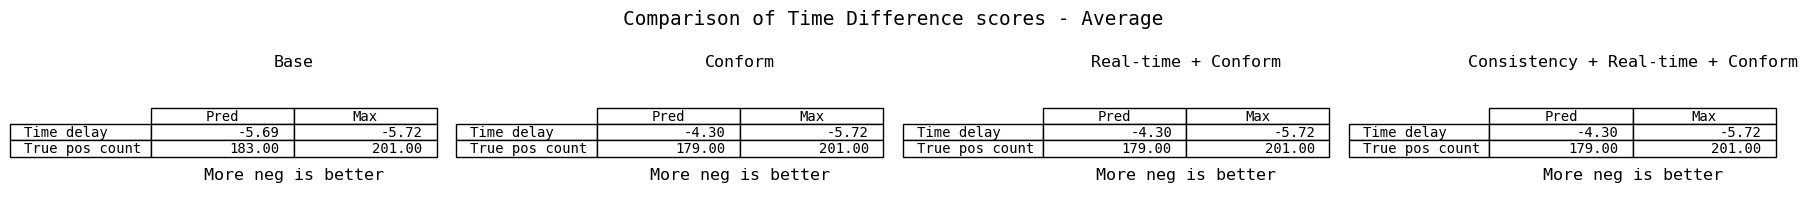

In [6]:
features = [
    "import_capacity",
    "time_since_last_two_sided",
    "PTU",
    "minute_in_ptu",
    "vwap_avg",
    "vwap_median",
    "vwap_qty_sum",
    "hvq_delta",
    "forecast_wind",
    "forecast_solar",
    "max_price_filled_known",
    "last_15min_up_volume"
]
print("Number of used features:", len(features))
splits = get_splits(df, features, target, return_dict_pair=False)


def train(train_in, train_out):
    model = RandomForestClassifier(n_jobs=-1)
    model = model.fit(train_in, train_out)
    return model


def test(model, test_in):
    pred = model.predict(test_in)
    return recast_pred(pred), pred

mask = splits[train_set][3]["min_ptu_price_known"] < 0

X_train = splits[train_set][0][mask]
y_train = splits[train_set][1][mask]

best2, _ = evaluate_income(train, test, X_train, y_train, splits[test_set][0], splits[test_set][3], repeat=1)

p2, p2p = test(best2[0], splits[test_set][0])
p = p2
show_metrics_adjusted(splits[test_set][3], p, version=version)

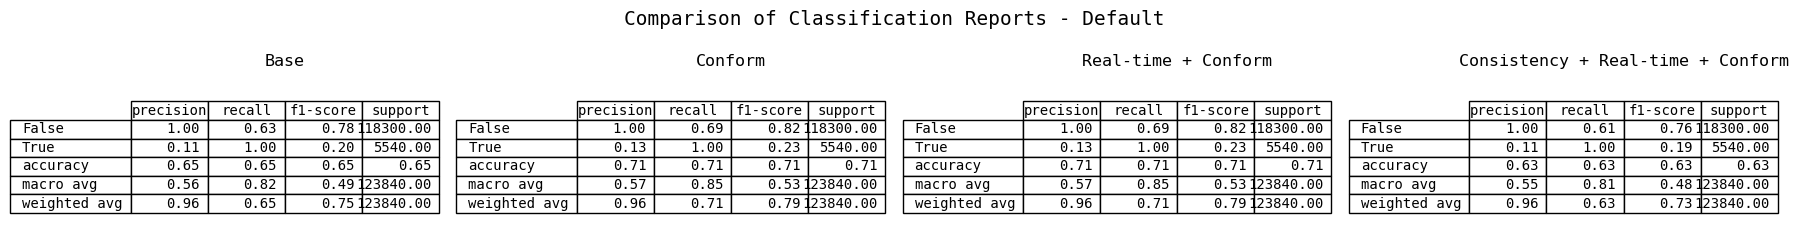

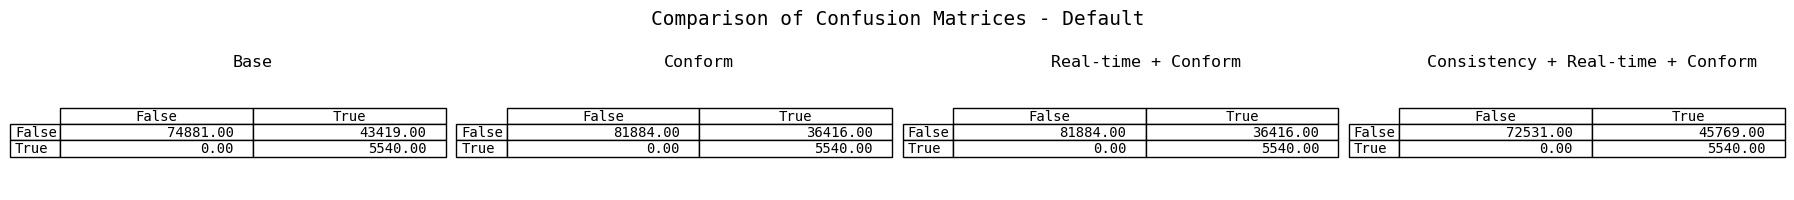

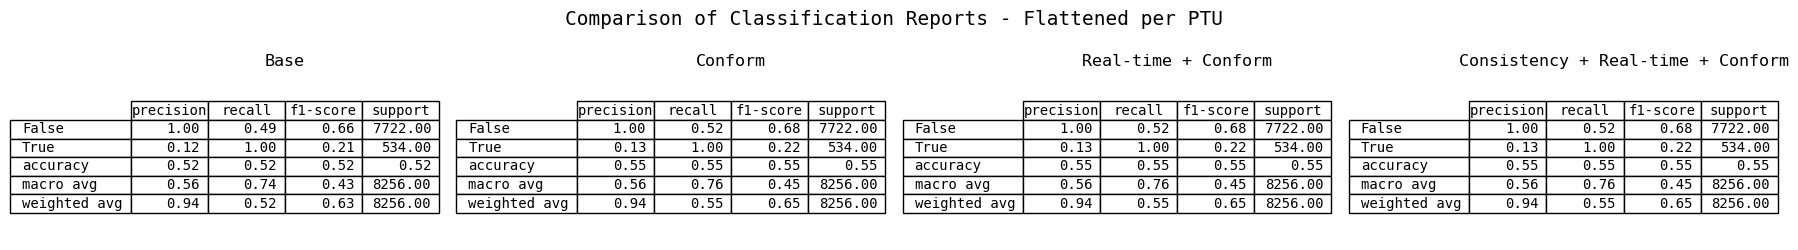

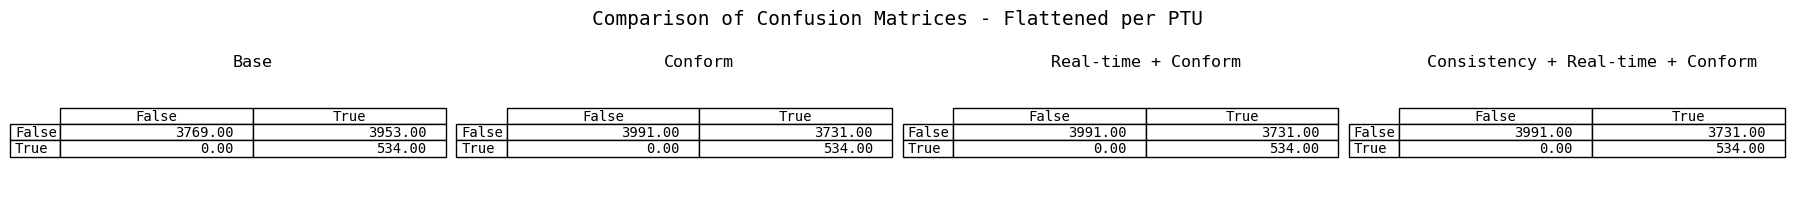

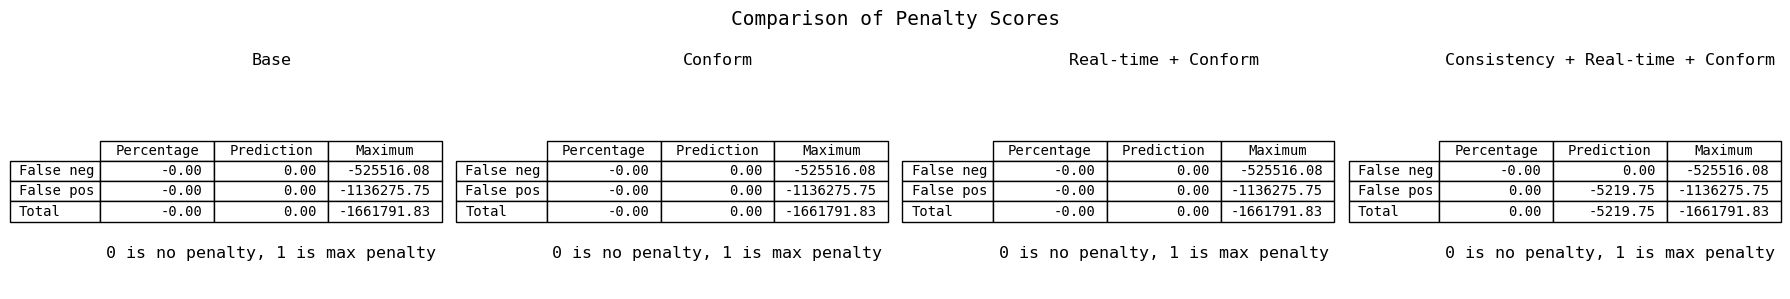

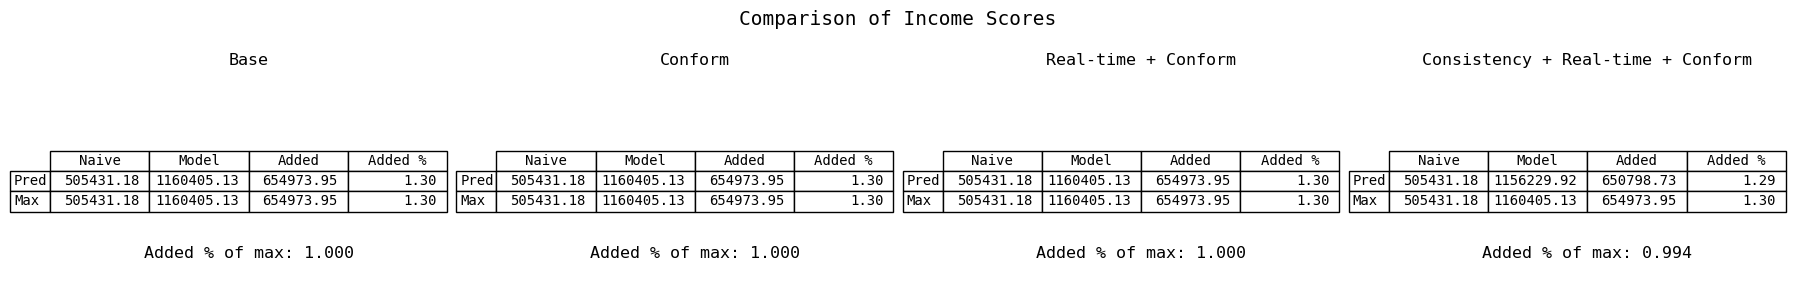

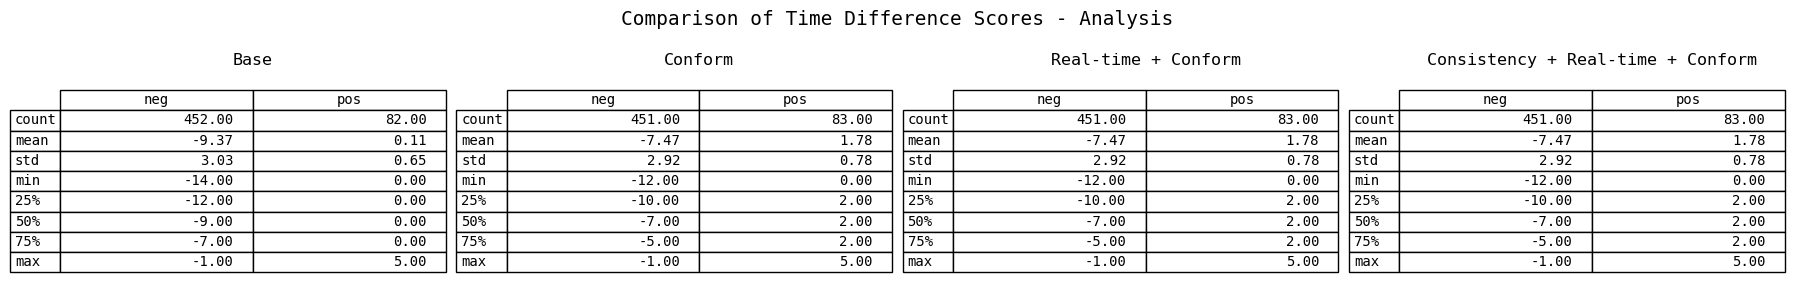

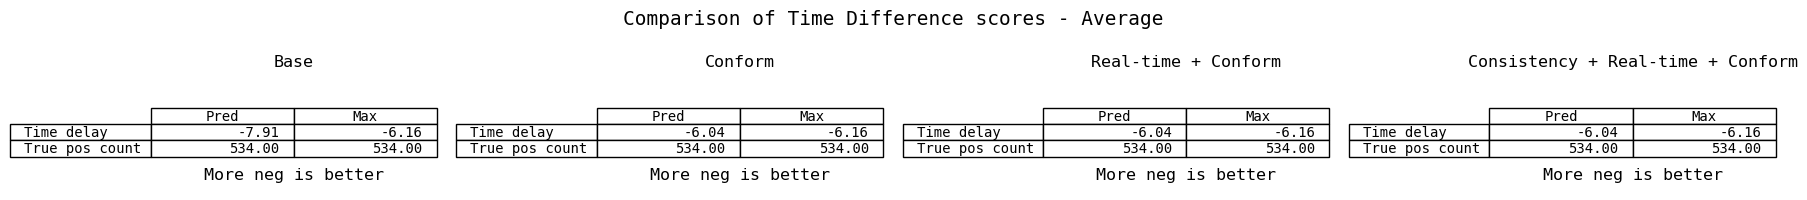

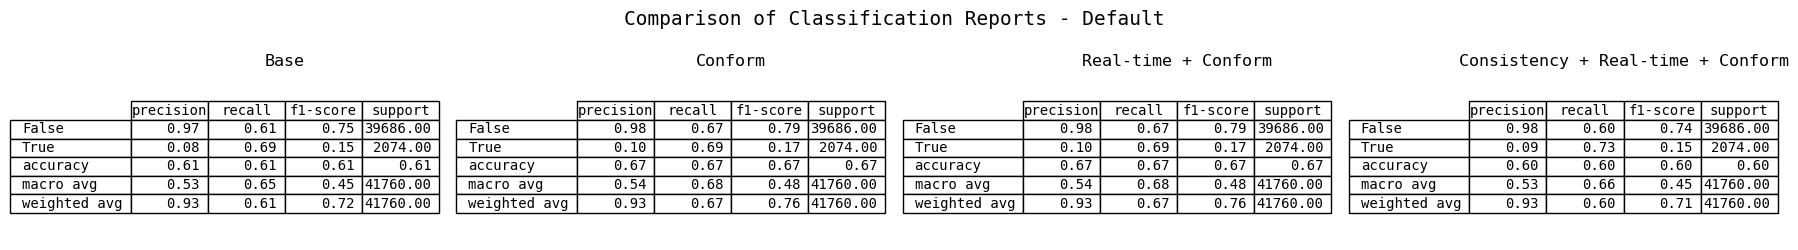

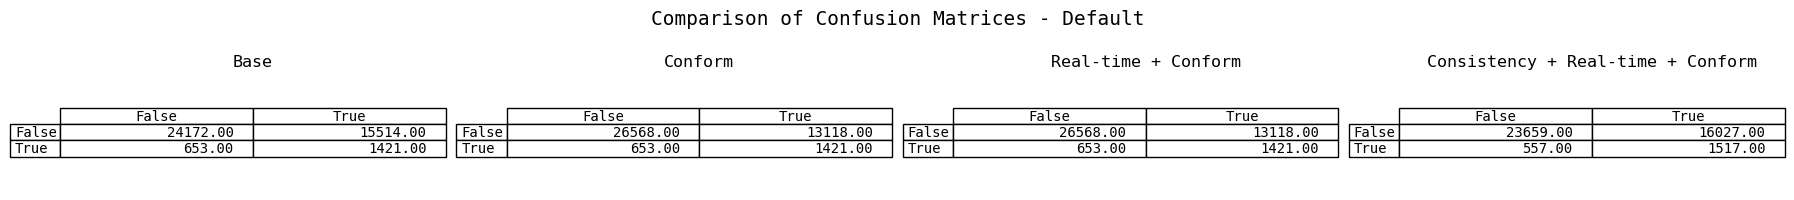

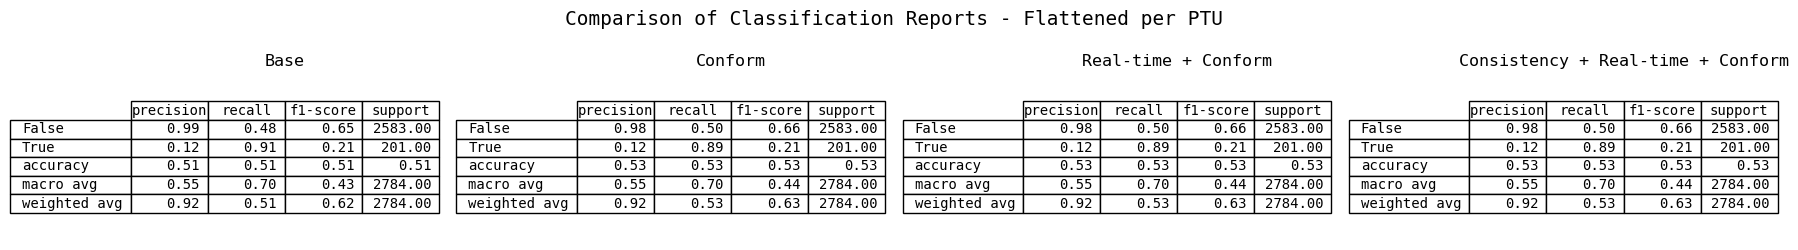

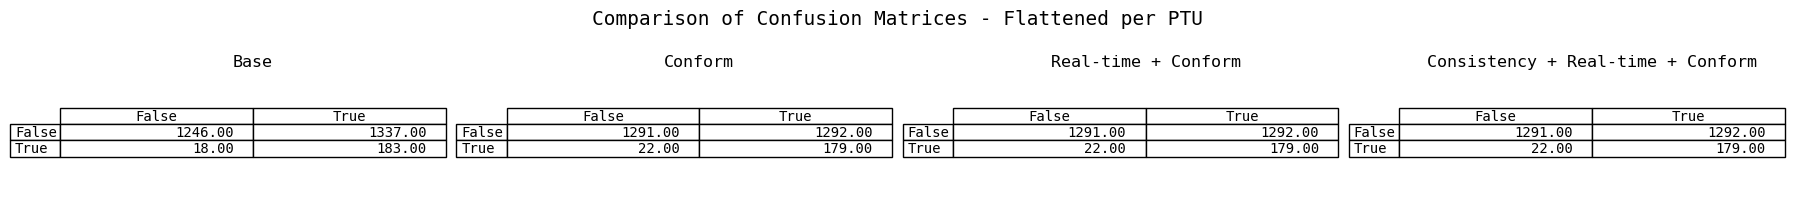

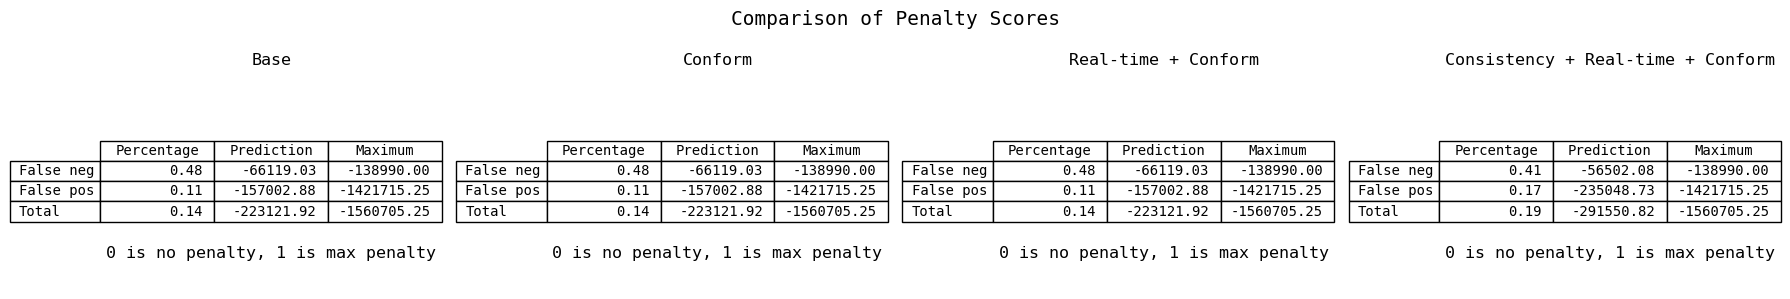

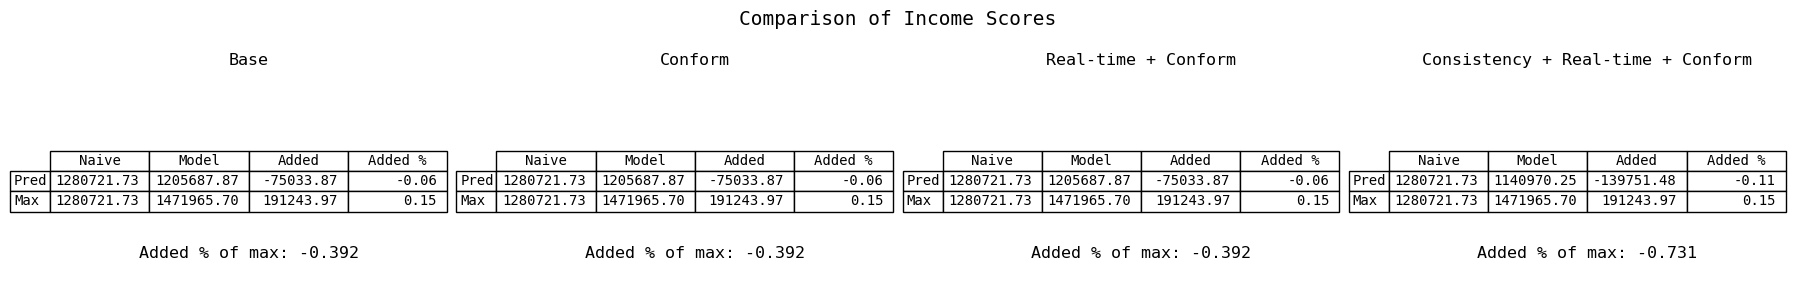

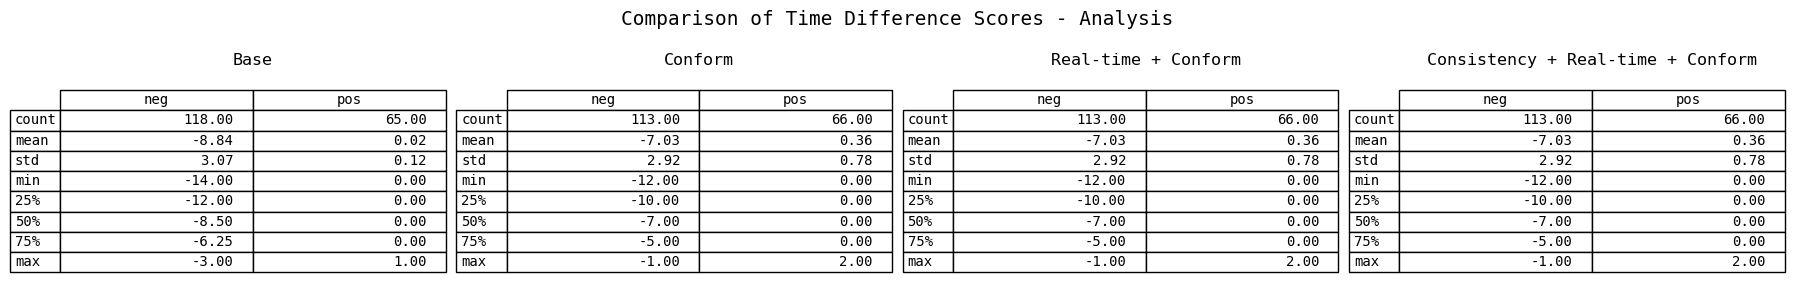

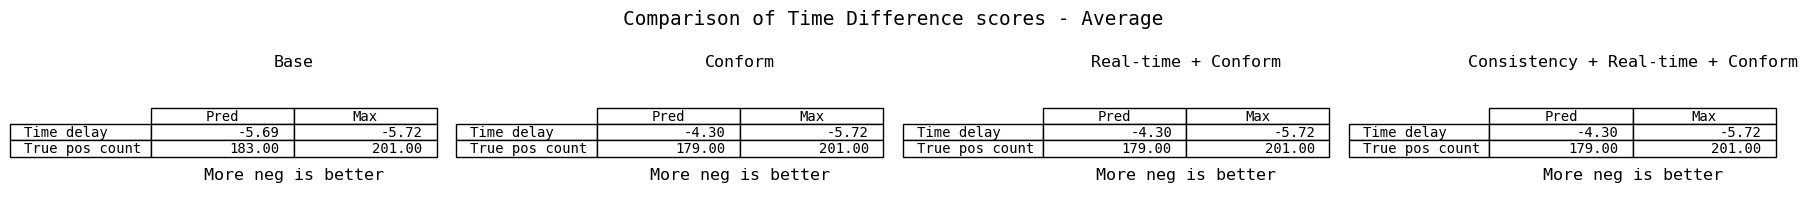

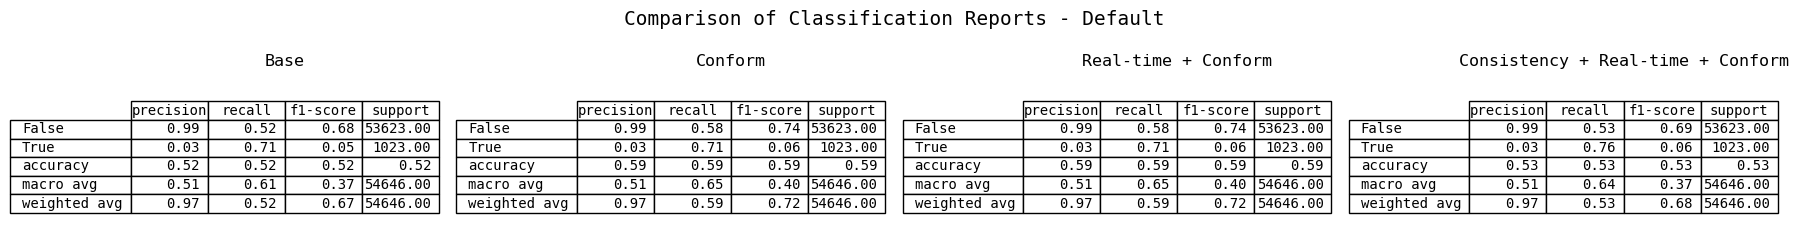

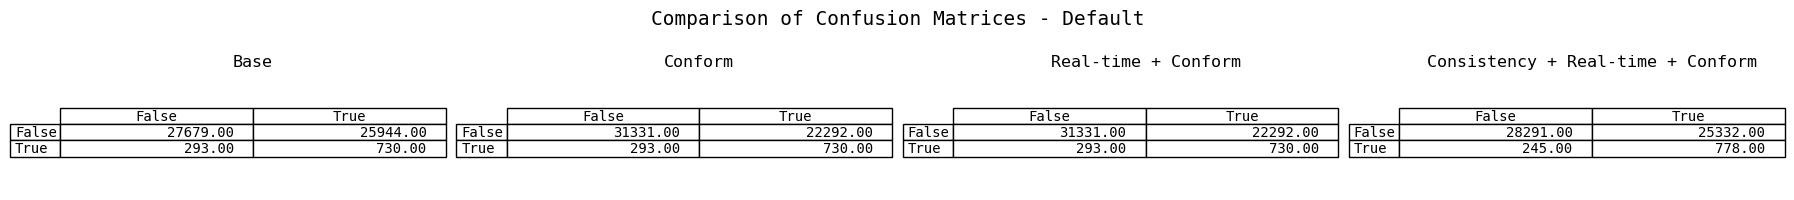

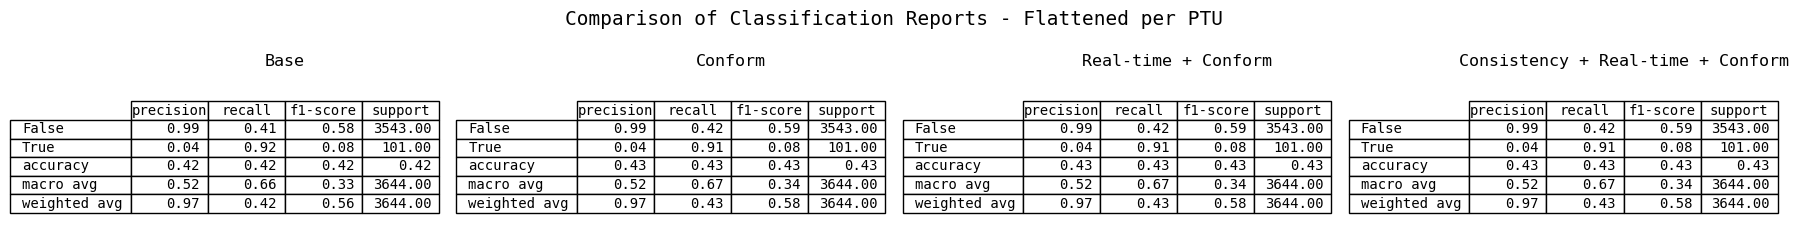

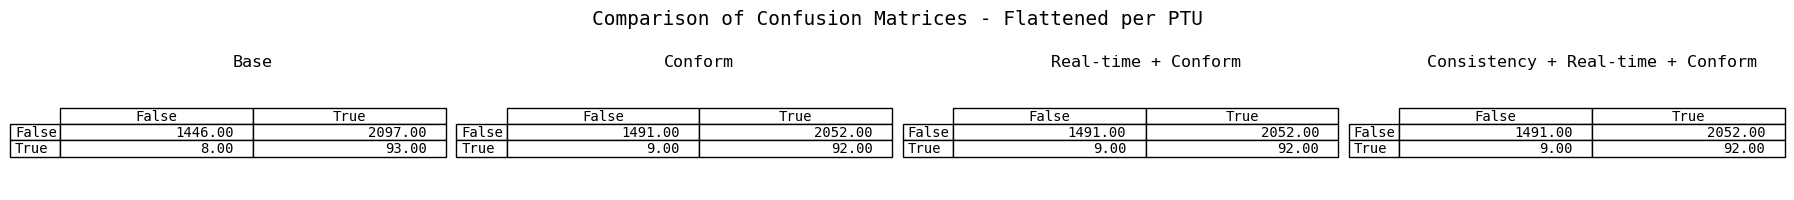

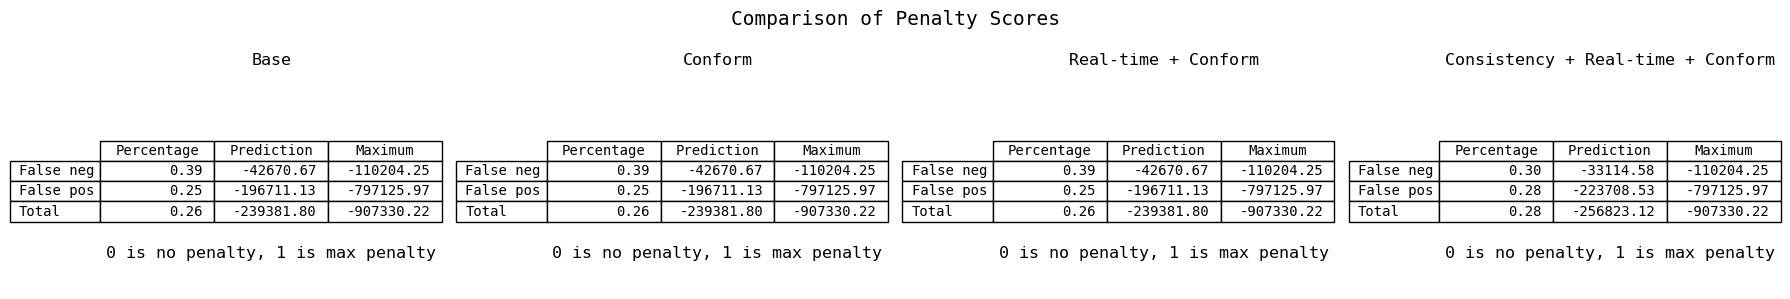

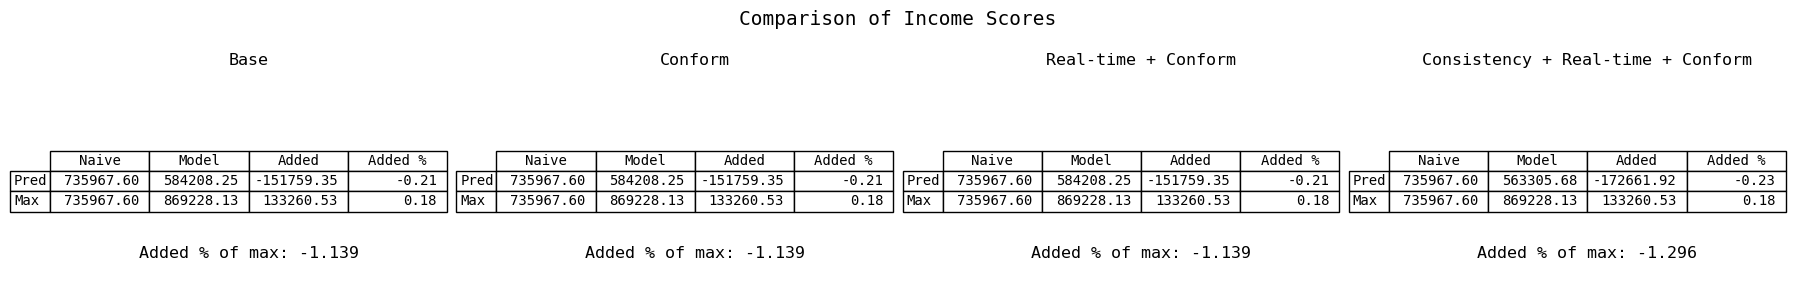

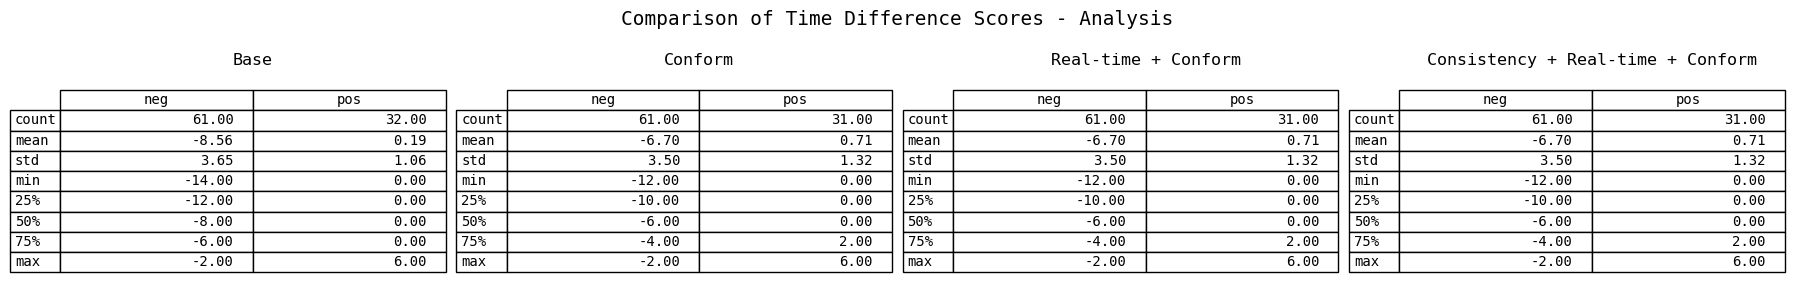

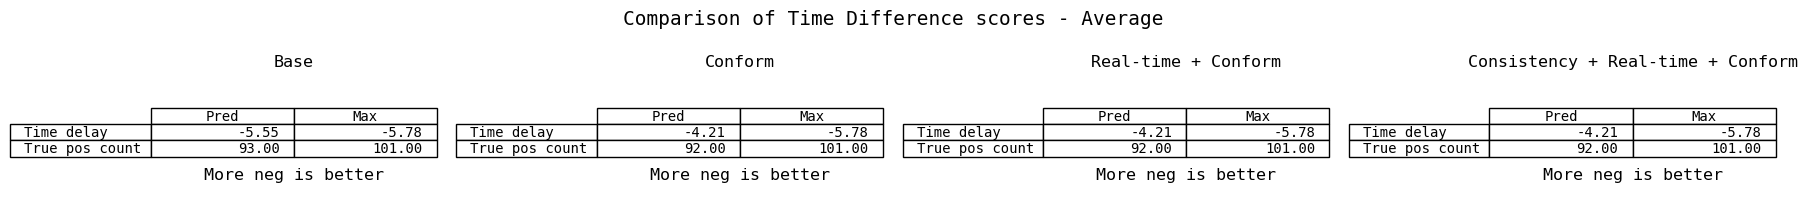

In [7]:
p_tr, _ = test(best2[0], splits["train"][0])
show_metrics_adjusted(splits["train"][3], p_tr, version=version)

p_va, _ = test(best2[0], splits["valid"][0])
show_metrics_adjusted(splits["valid"][3], p_va, version=version)

p_te, _ = test(best2[0], splits["test"][0])
show_metrics_adjusted(splits["test"][3], p_te, version=version)

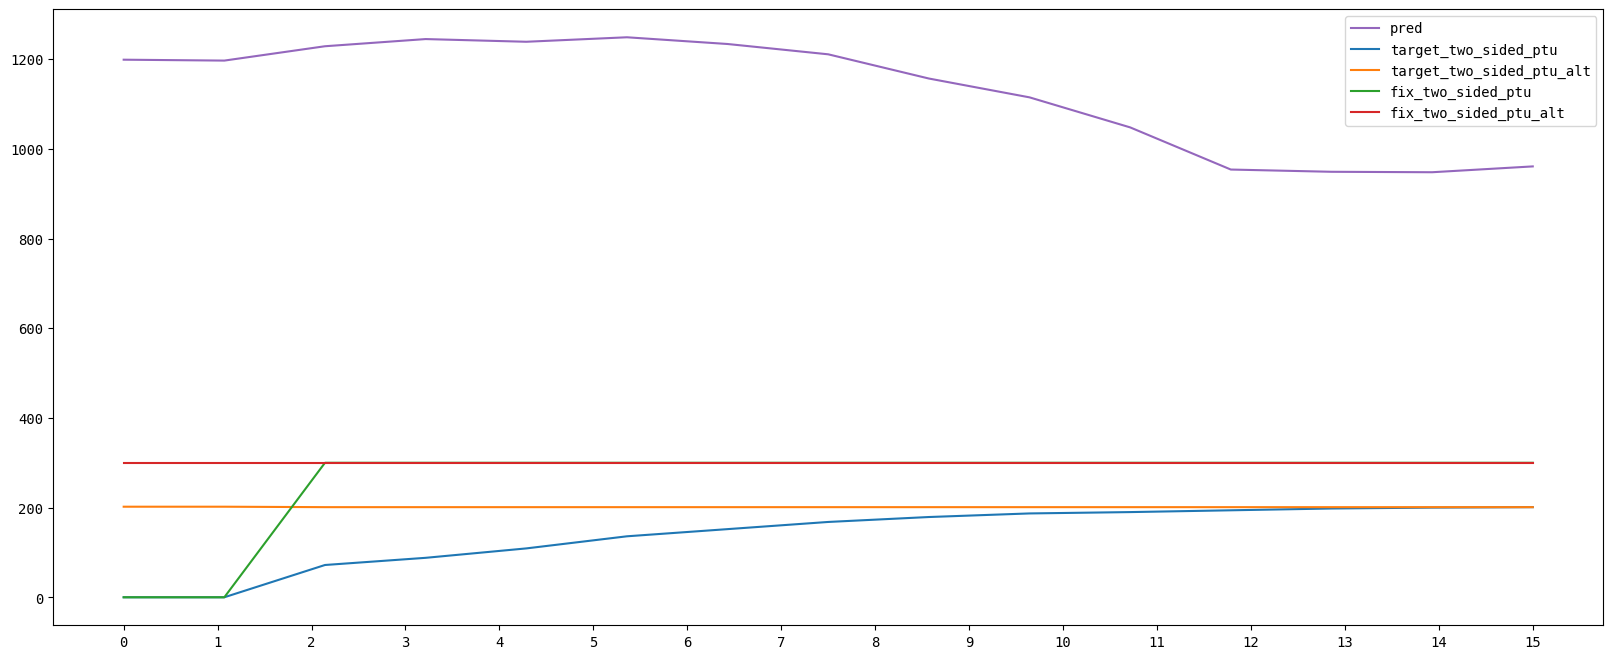

In [8]:
targets = [
    "target_two_sided_ptu",
    "target_two_sided_ptu_alt",
    "fix_two_sided_ptu",
    "fix_two_sided_ptu_alt",
    "pred"
]
agg_dict = {t: "sum" for t in targets}
view = splits[test_set][3]
view["pred"] = p2
items = 15
flat_df = view.groupby("minute_in_ptu").agg(agg_dict)
flat_df.index = np.linspace(0, items, items)

for t in targets:
    plot_against_index(flat_df[t], show=False)
plt.xticks(range(0, items + 1, 1))
show_graph()